In [147]:
import numpy as np
import pandas as pd
import os
from unidecode import unidecode


# ENGE pre 2016

In [148]:
#cargo y limpio data
vab_1 = pd.read_csv('../enge - producto.csv', skiprows=2)
emp_1 = pd.read_csv('../enge - empleo.csv', skiprows=2)
# emp_1 = emp_1.replace('.', '', regex=True)


def replace_points(df):
    # Iterate over each column
    for col in df.columns:
        if df[col].dtype == 'float':
            df[col] = df[col].astype(str).str.replace('.', '').astype(int)
            
    return df

def clean_col (df, col):
    df = df.replace(',', '', regex=True)

    df.columns = [ x.replace('  ', '').replace('\n', '').strip() for x in  df.columns]
        
    # Get the current column names
    # column_names = df.columns.tolist()
    # # print(column_names)
    # # Specify the index of the column you want to rename
    # column_index = 0
    # # Set the new column name at the specified index
    # column_names[column_index] = 'year'
    # Update the column names in the DataFrame
    # df.columns = column_names

    print(df.columns)
    
    df = df.melt(id_vars = 'year')

    df.rename(columns = {'value': col,
                        'variable': 'sector',
                        }, inplace = True)
    
    print(f'unque sectors: {len(df.sector.unique())}')
    
    #filtro año 2016 pero habria q buscarlo
    df = df[df['year'] < 2016]
    
    df[col] = df[col].astype(float) if col == 'vab' else df[col].astype(int)
    
    return df


# emp_1 = replace_points(emp_1)#

    
emp_1 = clean_col(emp_1, 'emp')
vab_1 = clean_col(vab_1, 'vab')

print(emp_1.info(), vab_1.info() )


Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
Index(['year', 'Total', 'Minas y canteras', 'Total Manufactura',
       'Alimentos, bebidas y tabaco', 'Combustibles, químicos y plásticos',
       'Maquinarias, equipos y vehículos', 'Resto industria (1)',
       'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
       'Resto actividades (2)'],
      dtype='object')
unque sectors: 11
<class 'pandas.core.frame.DataFrame'>
Int64Index: 253 entries, 0 to 262
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   year    253 non-null    int64 
 1   sector  253 non-null    object
 2   emp     253 non-null    int32 
dtypes: int3

In [149]:
#joineo
data_1 = pd.merge(vab_1,
         emp_1,
         how = 'left', 
         on = ['year', 'sector'])

data_1['sector'] = data_1['sector'].apply(unidecode)

len(data_1.sector.unique())

11

In [150]:
# data_1['productividad'] = data_1.vab/data_1.emp
# data_1

# ENGE post 2016

In [151]:
#cargo data

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current directory:", current_directory)

# List files in the current directory
def get_enge_data_2(current_directory):
    files = os.listdir(current_directory)
    data = pd.DataFrame()
    total_len = 0
    for file in files:
        if '.xls' in file: 
            # print(file)
            year = file.split('.')[0].split('_')[-1].strip()
            # print(year)
            # Specify the file path
            file_path =  current_directory + "/" + file

            # Specify the sheet name or index
            sheet_name = 'C11'  # You can also use the sheet index (0, 1, 2, etc.)

            # Read the Excel file
            df = pd.read_excel(file_path, sheet_name=sheet_name, skiprows  = 2)


            # Rename the columns starting with 'Unnamed'
            df.rename(columns=lambda x: df.iloc[0][x] if 'Unnamed' in str(x) else x, inplace=True)
            df.rename(columns={'Componente': 'componente', 
                               'Unidad de medida': 'unidad',
                    'Electricidad, gas, agua, residuos y saneamiento' : 'Electricidad, gas y agua',
                    'Servicios de información y comunicaciones': 'Comunicaciones',
                    'Industria manufacturera': 'Total Manufactura'
                    }, inplace = True)
            
            # Drop the first two rows
            df = df.drop([0, 1]).reset_index(drop=True)

            
            df = df.melt(id_vars = ['componente', 'unidad'], var_name = 'sector')

            # Filter rows that start with "Fuente"
            df.dropna(subset = ['componente'], inplace = True)
            df = df[~df['componente'].str.startswith('Fuente')  & df['componente'].notna()]

            df['year']= year    

            total_len += len(df)

            data = pd.concat([df, data])

    print(total_len)
    return data
data = get_enge_data_2(current_directory)
data.info()

Current directory: C:\Users\mateo\Documents\data\indec\enge
1050
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1050 entries, 0 to 237
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   componente  1050 non-null   object
 1   unidad      1050 non-null   object
 2   sector      1050 non-null   object
 3   value       1050 non-null   object
 4   year        1050 non-null   object
dtypes: object(5)
memory usage: 49.2+ KB


In [152]:
#calculo el index 

def get_index(df):
    # print(df.columns)
    # Pivot the dataframe
    pivot_df = df.pivot(values='value', index=['sector', 'year'], columns='componente')#.reset_index()#.drop(['componente'], axis =1)
    

    # Calculate the ratio
    # pivot_df['productividad'] = pivot_df['Valor agregado bruto'] / pivot_df['Puestos de trabajo asalariados']
    pivot_df['tasa_rentabilidad'] = pivot_df['Utilidad'] / pivot_df['Activo'] *100

    pivot_df.rename(columns = {'Valor agregado bruto': 'vab',
                              'Puestos de trabajo asalariados' : 'emp',
                              }, inplace = True)
    
    # print(pivot_df.columns)
    pivot_df.reset_index(inplace= True)
    pivot_df = pivot_df[['year', 'sector', 'vab' , 'emp' ]] # 'productividad'
    
    pivot_df['sector'] = pivot_df['sector'].apply(unidecode)

    return pivot_df.reset_index()
data_2  = get_index(data)

In [153]:
data_2.head(3)
# data_2.reset_index()
# data_2.index#iloc[:,1: ]#.index

componente,index,year,sector,vab,emp
0,0,2017,"Alimentos, bebidas y tabaco",318010.524911,137557
1,1,2018,"Alimentos, bebidas y tabaco",526944.771732,133637
2,2,2019,"Alimentos, bebidas y tabaco",787440.418027,130560


In [154]:
#veo los sectores presentes en cada conjunto de datos
dict_sectors = {}
for df_i, nam_i in zip([data_1, data_2 ], ['data_1', 'data_2']):
    unique_sectors = df_i.sector.unique()
    print(nam_i)
    # print(unique_sectors)
    print(len(unique_sectors))

    dict_sectors[nam_i] = unique_sectors
    
dict_sectors


data_1
11
data_2
16


{'data_1': array(['Total', 'Minas y canteras', 'Total Manufactura',
        'Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos',
        'Maquinarias, equipos y vehiculos', 'Resto industria (1)',
        'Total Servicios', 'Electricidad, gas y agua', 'Comunicaciones',
        'Resto actividades (2)'], dtype=object),
 'data_2': array(['Alimentos, bebidas y tabaco',
        'Combustibles, quimicos y plasticos', 'Comercio', 'Comunicaciones',
        'Construccion', 'Electricidad, gas y agua',
        'Maquinarias, equipos y vehiculos', 'Minas y canteras',
        'Minerales no metalicos, metales y productos de metal',
        'Otras actividades', 'Otros industria manufacturera',
        'Textiles y cuero', 'Textiles y cueros', 'Total',
        'Total Manufactura', 'Transporte, correo y almacenamiento'],
       dtype=object)}

In [155]:
#veo los sectores en comun
set1 = set(dict_sectors['data_1'])
set2 = set(dict_sectors['data_2'])

common_values = set1.intersection(set2)
print(len(common_values))
# common_values = common_values.astype(list)
print(type(common_values))
common_values

8
<class 'set'>


{'Alimentos, bebidas y tabaco',
 'Combustibles, quimicos y plasticos',
 'Comunicaciones',
 'Electricidad, gas y agua',
 'Maquinarias, equipos y vehiculos',
 'Minas y canteras',
 'Total',
 'Total Manufactura'}

In [156]:
#concateno la data y me quedo con los sectores en comun
data = pd.concat([data_1, data_2 ])
# Apply unidecode to all string columns
# data = data.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)

# Replace 'unique' with 'Resto industria' if not in common_values
data['sector'] = np.where(data['sector'].isin(common_values), data['sector'], 'Resto industria')
data['year'] = data['year'].astype(int)

unique_sectors = data.sector.unique()
print(unique_sectors)
print(len(unique_sectors))

['Total' 'Minas y canteras' 'Total Manufactura'
 'Alimentos, bebidas y tabaco' 'Combustibles, quimicos y plasticos'
 'Maquinarias, equipos y vehiculos' 'Resto industria'
 'Electricidad, gas y agua' 'Comunicaciones']
9


In [157]:
#agrego el resto de la industria
data = data.groupby(['year', 'sector']).agg(
    {'vab': 'sum',
     'emp': 'sum',
     # 'productividad': 'mean'
    }

    ).reset_index()

In [158]:
#cargo indices de precios y tcp
indices =  pd.read_excel('../TCP_me.xlsx', skiprows  = 2)
# print(indices)
indices.rename(columns = {
    'Unnamed: 0' : 'year',
    'Unnamed: 14' : 'TCP_1',
    'Unnamed: 15' : 'TCP_2',
        },
               inplace = True
              )
indices = indices.iloc[2:, :]
indices = indices[['year', 'IPC', 'TCC', 'TCP_1', 'TCP_2']]
indices['year'] = indices['year'].astype(int) #astype(str).str.strip(). 
# indices.year.tolist()

In [159]:
data_join = pd.merge(data,
         indices,
         how = 'left',
         on = 'year')

data_join['vab'] = data_join['vab'] #* 10e6
data_join['vab_ipc'] = data_join['vab']/data_join['IPC']
data_join['vab_tcp_1'] = data_join['vab']/data_join['TCP_1']

data_join['productividad_tcp_1'] = data_join['vab_tcp_1']/data_join['emp']
data_join['productividad_ipc'] = data_join['vab_ipc']/data_join['emp']

# data_join['prod_tcp'] = data_join['productividad']/data_join['TCP_1']
# data_join.to_csv('enge_results.csv')
data_join.head()

,year,sector,vab,emp,IPC,TCC,TCP_1,TCP_2,vab_ipc,vab_tcp_1,productividad_tcp_1,productividad_ipc
0,1993,"Alimentos, bebidas y tabaco",5636.0,110921.0,0.632744,0.99,1.997278,2.091472,8907.230586,2821.840264,0.025440,0.080302
1,1993,"Combustibles, quimicos y plasticos",5624.0,54652.0,0.632744,0.99,1.997278,2.091472,8888.265581,2815.832088,0.051523,0.162634
2,1993,Comunicaciones,3651.6,71426.0,0.632744,0.99,1.997278,2.091472,5771.050959,1828.288131,0.025597,0.080798
3,1993,"Electricidad, gas y agua",3076.2,54362.0,0.632744,0.99,1.997278,2.091472,4861.678979,1540.196065,0.028332,0.089432
4,1993,"Maquinarias, equipos y vehiculos",2289.0,47257.0,0.632744,0.99,1.997278,2.091472,3617.574665,1146.059681,0.024252,0.076551


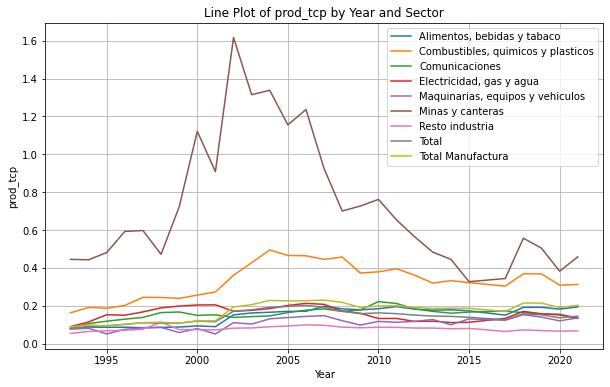

In [160]:
import pandas as pd
import matplotlib.pyplot as plt

variables = ['productividad_tcp_1' ,'productividad_ipc']
variable = variables[1]
# Assuming your dataframe is named 'df'
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Group the data by sector and plot each group separately
for sector, data in data_join.groupby('sector'):
    plt.plot(data['year'], data[variable], label=sector)

plt.xlabel('Year')
plt.ylabel('prod_tcp')
plt.title('Line Plot of prod_tcp by Year and Sector')
plt.legend()  # Show the legend with sector labels
plt.grid(True)  # Add a grid
plt.show()


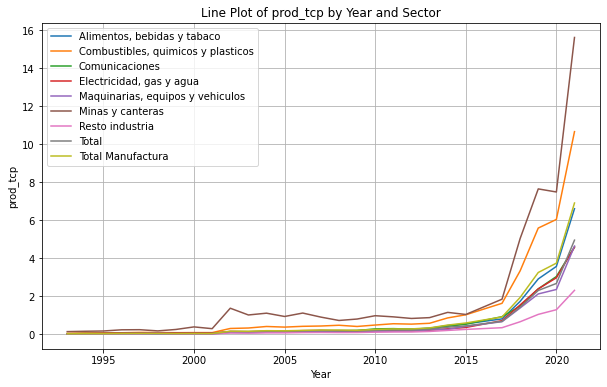

In [164]:
variable = variables[0]

# Assuming your dataframe is named 'df'
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed

# Group the data by sector and plot each group separately
for sector, data in data_join.groupby('sector'):
    plt.plot(data['year'], data[variable], label=sector)

plt.xlabel('Year')
plt.ylabel('prod_tcp')
plt.title('Line Plot of prod_tcp by Year and Sector')
plt.legend()  # Show the legend with sector labels
plt.grid(True)  # Add a grid
plt.show()

In [161]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Load the dataset
# # data = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual file path

# # Plot the 'productividad' variable colored by sector
# plt.scatter(data_join['year'], data_join['prod_tcp'], c=data_join['sector'], cmap='Set1')
# plt.xlabel('Year')
# plt.ylabel('Productividad')
# plt.title('Productividad by Sector')
# plt.colorbar(label='Sector')
# plt.show()


In [162]:
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import LabelEncoder

# # Load the dataset
# # data_join = pd.read_csv('your_dataset.csv')  # Replace 'your_dataset.csv' with the actual file path

# # Encode the 'sector' column to numeric values
# encoder = LabelEncoder()
# data_join['sector_encoded'] = encoder.fit_transform(data_join['sector'])

# # Plot the 'productividad' variable colored by sector
# plt.scatter(data_join['year'], data_join['productividad_tcp_1'], c=data_join['sector_encoded'], cmap='Set1')
# plt.xlabel('Year')
# plt.ylabel('Productividad')
# plt.title('Productividad by Sector')
# plt.colorbar(label='Sector')
# plt.show()


In [163]:

# Plot the 'productividad' variable colored by sector
# plt.scatter(data_join['year'], data_join['productividad'], c=data_join['sector'], cmap='Set1')
# plt.xlabel('Year')
# plt.ylabel('Productividad')
# plt.title('Productividad by Sector')
# plt.colorbar(label='Sector')
# plt.show()